# Object Tracker
[Implementation](./objecttracker.py)
[Configuration](./ObjectTracker.ini)

In contrast to the stateless ObjectFinder the ObjectTracker is a stateful class. The matching windows from ObjectFinder are tracked in a heatmap with integrating behaviour. From this heatmap the objects (vehicles) are extracted.

## Heatmap
The heatmap can be initialized with init_state() and with \_add\_heat() pixels where objects where found get hotter. In contrast with \_fade\_heat() the whole heatmap fades a set amount of heat. These methods are used to obtain an integrating behaviour of the heat map and suppress false detections. Only objects with several window matches for successive frames will build up sufficient heat. For one image frame in a video both functions are called once to test the integrating behaviour.

Parameters:
- threshold: Required heat to detect as object
- maxheat: To prevent windup the heat is capped
- fadeheat: Fading amount for each frame

Configurations:
- **threshold=4, maxheat=10, fadeheat=1**

Only one configuration is used here to verifiy the correct behaviour and object detection with static images. In the next step the full pipeline will be built to process videos an tweak these parameters.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2 cars found


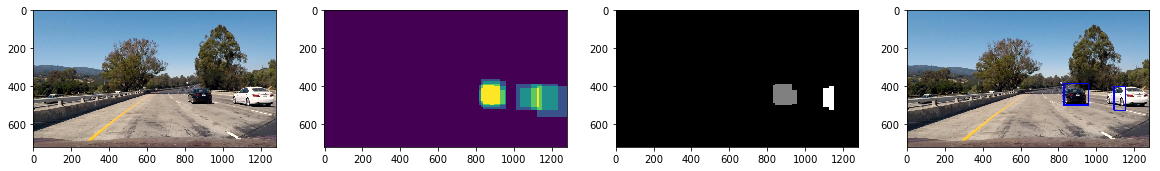

0 cars found


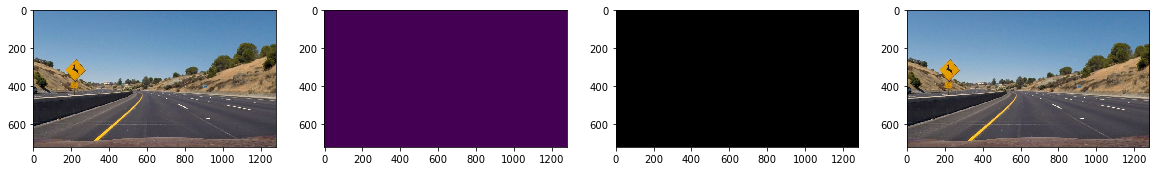

0 cars found


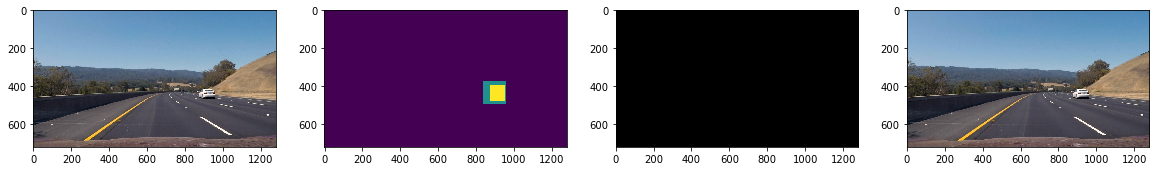

2 cars found


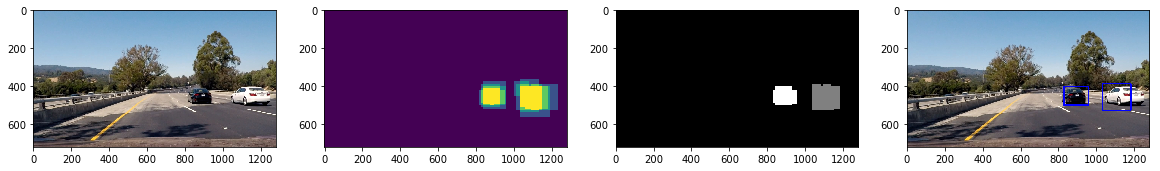

1 cars found


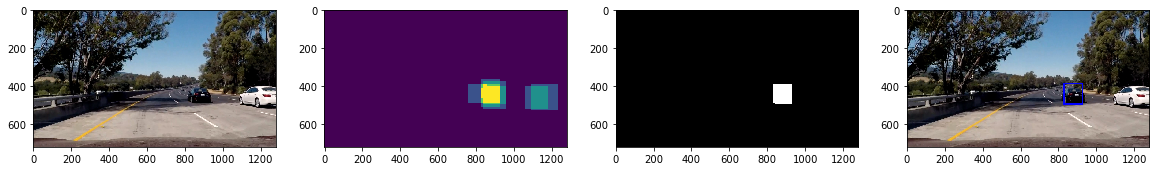

3 cars found


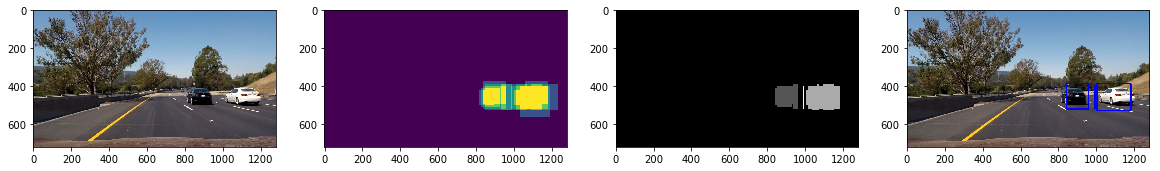

In [5]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from objecttracker import ObjectTracker
from images import ImageLoader

img_load = ImageLoader()
test_images = img_load.get_all('test')

config = {'heatmap' : {'threshold' : '4', 'maxheat' : '10', 'fadeheat' : '1'}}

obj_trk = ObjectTracker(clf='./classifier.pkl')
obj_trk.set_config(config)

for img in test_images:
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,4,1)
    plt.imshow(img)
    
    obj_trk._init_state()
    # Call heatmap several times to check integrating behaviour
    for i in range(3):
        heatmap = obj_trk._fade_heat()
        heatmap = obj_trk._add_heat(img)
    plt.subplot(1,4,2)
    plt.imshow(heatmap)
    
    labels = obj_trk._labels(heatmap)
    print(labels[1], 'cars found')
    plt.subplot(1,4,3)
    plt.imshow(labels[0], cmap='gray')
    
    img_bb = obj_trk._draw_boundingboxes(img, labels)
    plt.subplot(1,4,4)
    plt.imshow(img_bb)
    
    plt.show()

## Video processing
Finally the last step we process the test and project video and see how well we are doing :-).

And the result looks quite good. The vehicles are detected, but thresholds for the heatmap could be more optimized. The window size from sliding windows should also be better adapted to the expected vehicle sizes based on the image position. But overall I am quite satisified with the result.

In [2]:
%load_ext autoreload
%autoreload 2

from objecttracker import ObjectTracker

obj_trk = ObjectTracker(clf='./classifier.pkl')
obj_trk = ObjectTracker(clf='./classifiers/clf_svm1.pkl')

video_input = './test_video.mp4'
video_output = './videos/test_video_track.mp4'

obj_trk.detect_and_track_objects(video_input, video_output)

video_input = './project_video.mp4'
video_output = './videos/project_video_track.mp4'

obj_trk.detect_and_track_objects(video_input, video_output)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video ./videos/project_video_track.mp4
[MoviePy] Writing video ./videos/project_video_track.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:33:51<00:03,  3.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos/project_video_track.mp4 



In [3]:
from IPython.display import HTML
HTML("""
<video width="480" height="360" controls>
  <source src="./videos/test_video_track.mp4" type="video/mp4">
</video>
""")

In [4]:
from IPython.display import HTML
HTML("""
<video width="480" height="360" controls>
  <source src="./videos/project_video_track.mp4" type="video/mp4">
</video>
""")

# Discussion
To summarize the pipeline for vehicle detection and tracking consits of the following steps:
- FeatureExtractor with Spatial binning, Colorspace conversion and HOG 
- SVM classifier with rbg kernel and C=1 with >98% accuracy
- An object finder with sliding windows to efficiently detect objects in region of interests
- An object tracker with heatmap identification and tracking of objects by integration

Each was implemented as core module in a python file with a configuration .ini file. Parametersets for the pipeline steps were explored with Jupyter notebooks to determine the best fitting configuration.

## Optimization
In general further optimization and better result can be achieved by tuning all the parameters for the entire pipeline, and not only for a single pipeline step.

- FeatureExtractor: Better balance between the used feature vector length should give a more robust detection. Further the features are currently computed for each new sliding window without caching. Computation time could be speed up significantly with a caching algorithm.
- SVM classifier: The SVM classifier already works really well. More robustness could however be achieved by combining several classifiers.
- Sliding windows: The sliding windows now work quite statically. It would make sense to focus search on the sides are horizon where new vehicles are likely to appear. Already tracked vehicles can be robustly tracked with a hysteresis in the heatmap.
- Heatmap: Besides the integrating behaviour a hysteresis instead of the threshold should be used.

## Weakness
### Classification
The pipeline will fail for vehicles seen from the front. The classifier was only trained on data from vehicle as seen from the back or slightly sideways. It will also fail on other vehicles such as trucks, busses or motorcyclist. To include those objects a second classifier probably is better than trying to augment the existing classifier with more training data.

Varying weather (rain, mist, ...) and light condtions (dusk, night, ...) can also lead to false positive or no detection of objects. To work with those conditions image preprocessing could lead to better results.

### Video format
The pipeline and confiugration was built for a video of fixed size (1280x720). Videos with different resoulations will have wrong sliding windows algorithm. But this could be easily fixed by working with relative coordinates instead of absolute ones.